# Challenge 2

In [76]:
import pandas as pd 
import plotly.graph_objects as go
import plotly.express as px
from queue import PriorityQueue
from tqdm import tqdm

## Load the data

In [77]:
data = pd.read_csv('./Data/Cell_a.csv')
# Take CPU time in milliseconds
data['CPU'] = data.CPU.apply(lambda x: x*1000)
# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
display(data)

,Job_ID,Task_ID,Arrival_Time,CPU,Memory,X
0,375000667413,0,603026300,41.851044,0.001169,418.510437
1,375000669289,0,606413041,24.968147,0.001179,249.681473
2,375000670586,0,608994453,24.175644,0.001173,241.756439
3,375000670588,0,608994466,19.552231,0.001163,195.522308
4,375000670590,0,609042903,28.043747,0.001179,280.437469
...,...,...,...,...,...,...
2329128,400465219425,0,2678943690687,0.343323,0.000004,3.433228
2329129,400465219425,1,2678943690687,0.556946,0.000004,5.569458
2329130,400465256347,0,2678955330224,2.458572,0.000050,24.585724
2329131,400465256349,0,2678955330235,4.348755,0.000052,43.487549


In [63]:
test_data = data.iloc[list(range(100))]
test_data

,Job_ID,Task_ID,Arrival_Time,CPU,Memory,X
0,375000667413,0,603026300,41.851044,0.001169,418.510437
1,375000669289,0,606413041,24.968147,0.001179,249.681473
2,375000670586,0,608994453,24.175644,0.001173,241.756439
3,375000670588,0,608994466,19.552231,0.001163,195.522308
4,375000670590,0,609042903,28.043747,0.001179,280.437469
...,...,...,...,...,...,...
95,375000689249,31,648209781,24.834633,0.000742,248.346329
96,375000689249,1,648209781,25.558472,0.000731,255.584717
97,375000689249,37,648209781,21.108627,0.000802,211.086273
98,375000689249,3,648209781,24.940491,0.000761,249.404907


<AxesSubplot: >

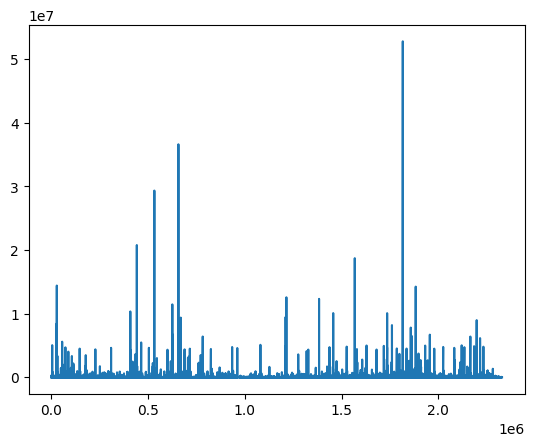

In [10]:
data['CPU'].plot()

<AxesSubplot: >

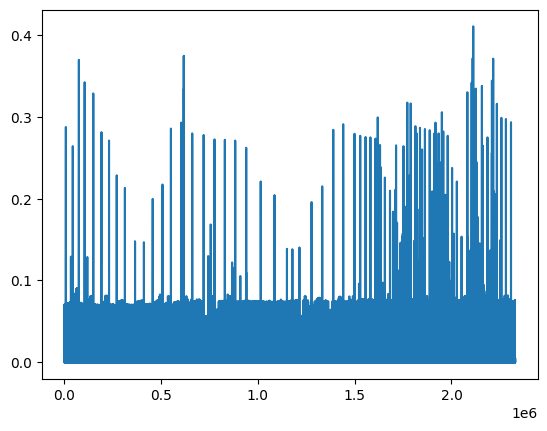

In [11]:
data['Memory'].plot()

<AxesSubplot: >

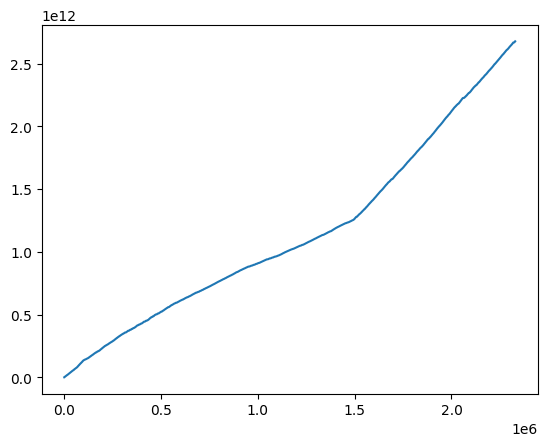

In [15]:
data['Arrival_Time'].plot()

In [78]:
servers = dict([(i+1, {'queue':[], 'Memory': 1, 'current_task': None, 'Unfinished_work': 0}) for i in range(64)])

In [79]:
data.head()

,Job_ID,Task_ID,Arrival_Time,CPU,Memory,X
0,375000667413,0,603026300,41.851044,0.001169,418.510437
1,375000669289,0,606413041,24.968147,0.001179,249.681473
2,375000670586,0,608994453,24.175644,0.001173,241.756439
3,375000670588,0,608994466,19.552231,0.001163,195.522308
4,375000670590,0,609042903,28.043747,0.001179,280.437469


In [169]:
# Shortest Remaining Processing Time (SRPT)
def Scheduling(new_time, prev_time, servers, data):
    # How much time has passed
    time = new_time - prev_time
    # To store the possible completed tasks
    completed = []
    # Iterating over the servers
    for i, server in servers.items():
        if(server['current_task'] == None and len(server['queue']) == 0):
            continue

        if(server['current_task'] != None):
            # Extract the current task
            task = server['current_task']
            server['current_task'] = None

            # If the current task has finished 
            if(data.at[task, 'X']-time <= 0):
                # store it in the completed list with it's finishing time
                completed.append((task, prev_time + data.at[task, 'X'] - data.at[task, 'Arrival_Time']))
                server['Memory'] += data.at[task, 'Memory']
            # Else
            else:
                # Update the remaining time
                remaining_time = data.at[task, 'X'] - time
                data.at[task,'X'] = remaining_time
                # And move the current task to the server queue
                server['queue'].append(task) 

        if(len(server['queue']) != 0):
            # Select the new current task as the one with less remaining time
            server['current_task'] = data.loc[server['queue'],'X'].sort_values().index[0]
            # And remove from the queue the new current task
            server['queue'].remove(server['current_task'])
        
    return completed

In [89]:
def Update_UW(time, servers, data, task, selected_server = 0):
    for i, server in servers.items():
        if(server['current_task'] != None):
            server['Unfinished_work'] = max([0, server['Unfinished_work'] - min([time, data.at[server['current_task'], 'X']])])

    if (selected_server != 0):
        servers[selected_server]['Unfinished_work'] += data.at[task, 'X']

In [90]:
# JBT
def Dispatching(servers, task, data, time):
    # Unfinished_work
    lower = min([server['Unfinished_work'] for server in servers.values()])
    possible_servers = [i for i, v in servers.items() if v['Unfinished_work'] <= (1+0.25)*lower]
    possible_servers = [(i, v['Memory']) for i, v in servers.items() if i in possible_servers and (v['Memory'] - data.at[task, 'Memory'])>=0]
    selected_server = sorted(possible_servers, reverse=True, key = lambda x: x[1])[0][0]

    # Add new task to server
    servers[selected_server]['queue'].append(task)
    servers[selected_server]['Memory'] -= data.at[task, 'Memory']

    # Updata the unfinished work
    Update_UW(time, servers, data, task, selected_server) 

    return(selected_server)


In [174]:
data = pd.read_csv('./Data/Cell_a.csv')
# Take CPU time in milliseconds
data['CPU'] = data.CPU.apply(lambda x: x*1000)
# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
type_dict = {'Job_ID':'int64','Task_ID':'int16','Arrival_Time':'int64','CPU':'float64','Memory':'float64','X':'float64'}
data.astype(type_dict).dtypes
test_data = data.iloc[list(range(100))]
servers = dict([(i+1, {'queue':[], 'Memory': 1, 'current_task': None, 'Unfinished_work': 0}) for i in range(64)])

In [175]:
results = []
used_data = []
current_data = pd.DataFrame(columns=data.columns).astype(type_dict)
prev_time = test_data.iloc[0].Arrival_Time
for job in tqdm(range(len(test_data))):
    current_data.loc[job] = data.iloc[job]
    new_time = current_data.at[job,'Arrival_Time']
    # Assegna a server secondo Unfinished_work
    selected_server = Dispatching(servers, job, current_data, new_time - prev_time)
    
    # Fai update
    completed = Scheduling(new_time, prev_time, servers, current_data)
    if(len(completed)):
        results = results + completed

    current_data.drop([i for i, v in completed], inplace=True)
    used_data.append(len(current_data))
    prev_time = new_time

100%|██████████| 100/100 [00:00<00:00, 179.30it/s]
